# GARLIC demo

General-purpose Adaptive Richardson-Lucy Image Characterisation

# 1. Initialisation

## Import libraries and scripts

In [144]:
%matplotlib ipympl
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.ticker import AutoMinorLocator

import ipywidgets as widgets
from IPython.display import display

import numpy as np
from time import time
from scipy import ndimage

import importlib
import scripts
importlib.reload(scripts)

> DEBUG: all scripts have been reloaded


<module 'scripts' from '/home/yago/public/git/paranoya/image-processing/scripts/__init__.py'>

Plotting:

In [2]:
def new_figure(fig_name, figsize=(10, 5), nrows=1, ncols=1, sharex='col', sharey='row', gridspec_kw={'hspace': 0, 'wspace': 0}):
    plt.close(fig_name)
    fig = plt.figure(fig_name, figsize=figsize)
    axes = fig.subplots(nrows=nrows, ncols=ncols, squeeze=False,
                        sharex=sharex, sharey=sharey,
                        gridspec_kw=gridspec_kw
                       )
    fig.set_tight_layout(True)
    for ax in axes.flat:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
        ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
        ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
        ax.grid(True, which='both')

    fig.suptitle(fig_name)
    
    return fig, axes

In [154]:
default_cmap = plt.get_cmap("gist_earth").copy()
default_cmap.set_bad('gray')


def colour_map(ax, cblabel, data, cmap=default_cmap, norm=None, xlabel=None, x=None, ylabel=None, y=None, projection_axis=0):

    if projection_axis is None:
        projection = data
    else:
        #projection = np.nanmean(data, axis=0)
        #projection = np.nanmean((data - np.nanmean(data, axis=0))**3, axis=0)
        projection = np.nanmax(data, axis=0)

    percentiles = np.array([1, 16, 50, 84, 99, 100])
    ticks = np.nanpercentile(projection, percentiles)
    if norm is None:
        if ticks[-1] > 0:
            linthresh = np.median(projection[projection > 0])
            #print(linthresh)
            norm = colors.SymLogNorm(vmin=ticks[0], vmax=ticks[-1], linthresh=linthresh)
        else:
            norm = colors.Normalize(vmin=ticks[0], vmax=ticks[-1])

    if y is None:
        y = np.arange(projection.shape[0])
    if x is None:
        x = np.arange(projection.shape[1])

    im = ax.imshow(projection,
                   extent=(x[0]-(x[1]-x[0])/2, x[-1]+(x[-1]-x[-2])/2, y[0]-(y[1]-y[0])/2, y[-1]+(y[-1]-y[-2])/2),
                   interpolation='nearest', origin='lower',
                   cmap=cmap,
                   norm=norm,
                  )
    ax.set_aspect('auto')
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)

    cb = fig.colorbar(im, ax=ax, orientation='vertical', shrink=.9)
    cb.ax.set_ylabel(cblabel)
    if ticks is not None:
        cb.ax.set_yticks(ticks=ticks, labels=[f'{value:.3g} ({percent}%)' for value, percent in zip(ticks, percentiles)])
    cb.ax.tick_params(labelsize='small')
    
    return im, cb, norm


## Read data

In [96]:
importlib.reload(scripts.read_data)
object_name, data, true_spectrum = scripts.read_data.run(35, (0, 0, 1))
data_offset = np.nanmin(data)

Read dataset 35: "Section (0, 0, 1) in Tobias' synthetic datacube" (175, 190, 190) (0.0862 s)


In [97]:
data_cmap = default_cmap
data_norm = colors.LogNorm(vmin=np.percentile(data[data>0], 10), vmax=np.percentile(data[data>0], 99))

# 2. Diffuse emission

In [98]:
importlib.reload(scripts.diffuse_emission)
n_minima = np.count_nonzero(scripts.diffuse_emission.find_minima(data))
n_valid = np.count_nonzero(np.isfinite(data))
compact_scale = np.power(n_valid / n_minima, 1/data.ndim)
print(f'compact scale = {compact_scale:.2f} ({n_valid} / {n_minima})')

compact scale = 4.73 (6317500 / 59633)


In [99]:
background = np.nanmin(data)
compact_FWHM = compact_scale
compact_sigma = compact_FWHM / np.sqrt(8*np.log(2))
min_radius = compact_sigma
print(f'background={background:4g}, min_radius={min_radius:.2f}')

background=-0.697771, min_radius=2.01


In [100]:
importlib.reload(scripts.multiscale_RL)
mRL_compact = scripts.multiscale_RL.run(data - background, min_radius, 0.01, 100)

iteration 1/100: rms_residual = 1.33e-01 (+98.03%), -- [-0.30155733]
iteration 2/100: rms_residual = 1.25e-01 (-6.31%), -- [1.79326347e-05]
iteration 3/100: rms_residual = 1.22e-01 (-2.53%), -- [6.31852143e-05]
iteration 4/100: rms_residual = 1.20e-01 (-1.53%), -- [8.13595244e-05]
iteration 5/100: rms_residual = 1.19e-01 (-1.08%), -- [0.00010542]
iteration 6/100: rms_residual = 1.18e-01 (-0.82%), -- [0.0001011]
Multiscale Richardson-Lucy deconvolution (2.89 s)


In [101]:
importlib.reload(scripts.diffuse_emission)
smooth = ndimage.gaussian_filter(mRL_compact[0], min_radius)
n_minima = np.count_nonzero(scripts.diffuse_emission.find_minima(smooth))
n_valid = np.count_nonzero(np.isfinite(smooth))
diffuse_scale = np.power(n_valid / n_minima, 1/data.ndim)
print(f'diffuse scale = {diffuse_scale:.2f} ({n_valid} / {n_minima})')

diffuse scale = 9.21 (6317500 / 8090)


In [102]:
smoothing_radii = np.array([min_radius, diffuse_scale])
#mRL = np.vstack([mRL_compact, mRL_diffuse])

importlib.reload(scripts.multiscale_RL)
mRL = scripts.multiscale_RL.run(data - background, smoothing_radii, 0.01, 100)

iteration 1/100: rms_residual = 1.33e-01 (+98.03%), -- [-0.30155733 -0.30155733]
iteration 2/100: rms_residual = 1.28e-01 (-3.57%), -- [0.34922481 0.3492123 ]
iteration 3/100: rms_residual = 1.25e-01 (-2.21%), -- [0.34891865 0.34956703]
iteration 4/100: rms_residual = 1.24e-01 (-1.53%), -- [0.3484687 0.3500621]
iteration 5/100: rms_residual = 1.22e-01 (-1.13%), -- [0.34794314 0.35061674]
iteration 6/100: rms_residual = 1.21e-01 (-0.89%), -- [0.3473898  0.35119533]
Multiscale Richardson-Lucy deconvolution (9.25 s)


In [103]:
compact_emission = ndimage.gaussian_filter(mRL[0], smoothing_radii[0])
diffuse_emission = ndimage.gaussian_filter(mRL[1], smoothing_radii[1])

In [104]:
tope = (data - background)/2
tope[~np.isfinite(tope)] = np.nanmean(tope)
diffuse_test_RL = 2 * np.clip(2*mRL[1] - mRL[0], a_min=0, a_max=tope)
diffuse_test = background + ndimage.gaussian_filter(diffuse_test_RL, smoothing_radii[1])
compact_test = ndimage.gaussian_filter(np.sum(mRL, axis=0) - diffuse_test_RL, smoothing_radii[0])

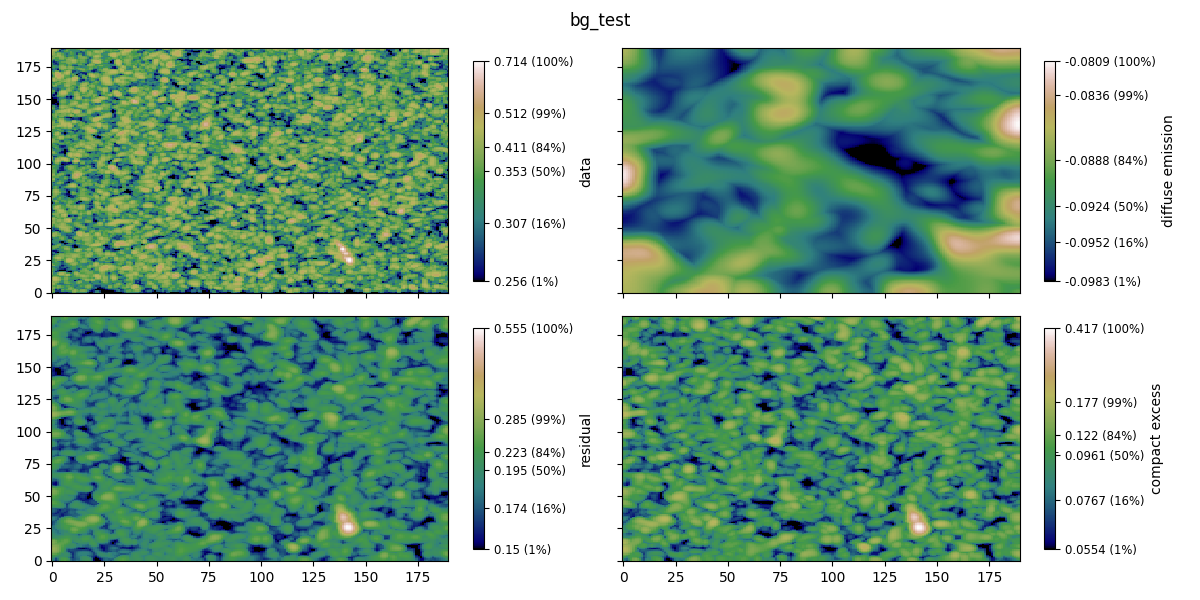

In [171]:
fig_name = 'bg_test'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(12, 6))
axes = fig.subplots(nrows=2, ncols=2, squeeze=False, sharex=True, sharey=True)
fig.suptitle(fig_name)
fig.set_tight_layout(True)


ax = axes[0, 0]
norm = colour_map(ax, 'data', data)[2]

ax = axes[0, 1]
#colour_map(ax, 'diffuse emission', background + diffuse_emission)#, norm=norm)
#colour_map(ax, 'diffuse emission', background + mRL[1])
colour_map(ax, 'diffuse emission', diffuse_test)

ax = axes[1, 0]
#norm = colour_map(ax, 'residual', data - background - diffuse_emission)[2]
#colour_map(ax, 'residual', compact_emission - diffuse_emission)
colour_map(ax, 'residual', background + compact_emission + diffuse_emission - diffuse_test)

ax = axes[1, 1]
#colour_map(ax, 'compact emission', mRL[0])
colour_map(ax, 'compact excess', compact_emission - diffuse_emission)
#colour_map(ax, 'compact emission', compact_test)
#cb = colour_map(ax, 'compact emission', compact_emission)[1]
#cb.ax.axhline(residual_above_bg, c='w')
#ax.contour(compact_emission - diffuse_emission, levels=[0], color='k')

plt.show()

In [106]:
background, np.nansum(data-background), np.sum(mRL), np.mean(mRL, axis=(1, 2, 3))

(-0.69777083, 4412747.5, 4412748.4051137, array([0.35181615, 0.34667984]))

In [107]:
np.nanmedian(data), np.nanmedian(mRL, axis=(1, 2, 3))+background/2

(0.0006718129, array([-0.00068567, -0.00221225]))

In [108]:
np.nansum(compact_emission - diffuse_emission), np.nansum(mRL[0] - mRL[1]), np.nansum(compact_emission), np.nansum(diffuse_emission)

(32448.58992245857, 32448.589922457715, 2222598.4975180784, 2190149.90759562)

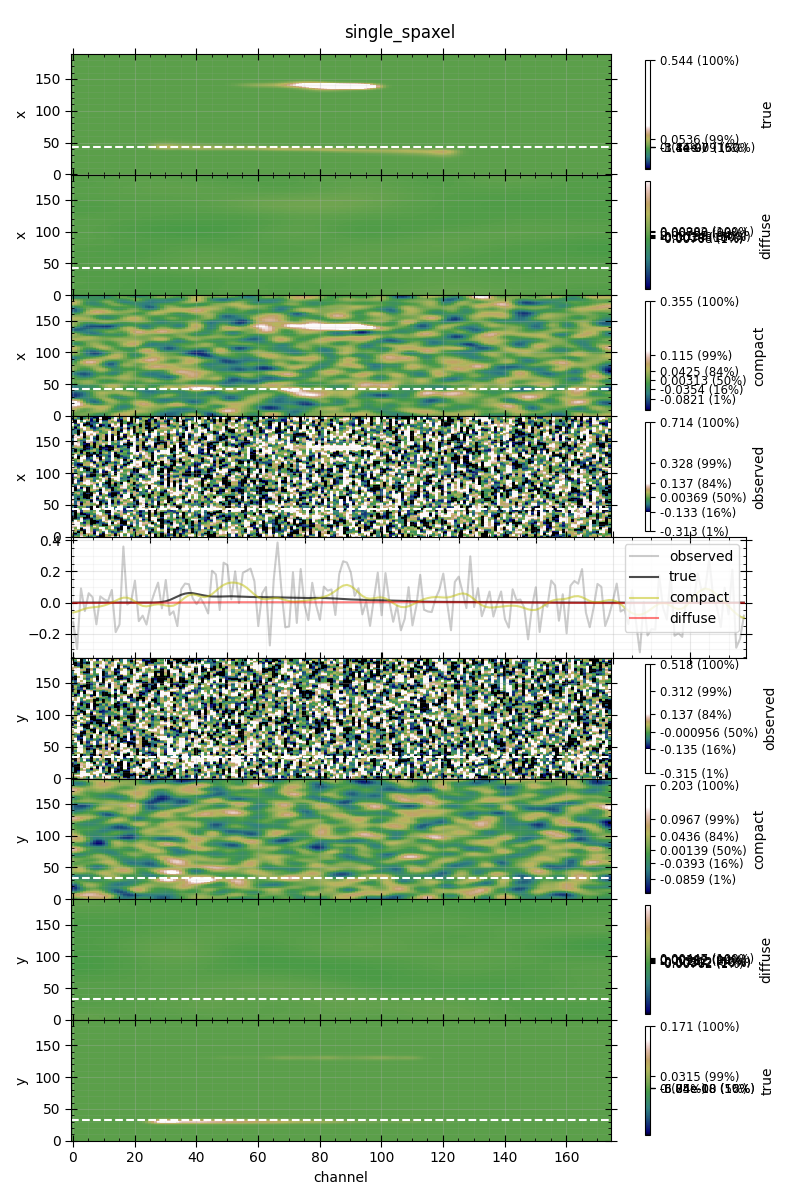

33 43 2.1401824006512156


In [175]:
index_y = np.random.randint(0, data.shape[1]); index_x = np.random.randint(0, data.shape[2])
#index_y = 132; index_x = 137
index_y = 21; index_x = 143
index_y = 33; index_x = 139
index_y = 33; index_x = 43
#index_y = 133; index_x = 139

fig, axes = new_figure('single_spaxel', figsize=(8, 12), nrows=9, sharex='col')

for ax in axes.flat:
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
    ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
    ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
    ax.grid(True, which='both')

vmin, vmax = np.nanpercentile(data, [16, 84])
norm = colors.Normalize(vmin, vmax)

ax = axes[0, 0]
colour_map(ax, 'true', true_spectrum[:, index_y, :].T, projection_axis=None, norm=norm)
ax.axhline(index_x, c='w', ls='--')
ax.set_ylabel('x')

ax = axes[1, 0]
colour_map(ax, 'diffuse', background/2 + diffuse_emission[:, index_y, :].T, projection_axis=None, norm=norm)
ax.axhline(index_x, c='w', ls='--')
ax.set_ylabel('x')

ax = axes[2, 0]
colour_map(ax, 'compact', background/2 + compact_emission[:, index_y, :].T, projection_axis=None, norm=norm)
ax.axhline(index_x, c='w', ls='--')
ax.set_ylabel('x')

ax = axes[3, 0]
colour_map(ax, 'observed', data[:, index_y, :].T, projection_axis=None, norm=norm)
ax.axhline(index_x, c='w', ls='--')
ax.set_ylabel('x')

ax = axes[4, 0]
ax.plot(data[:, index_y, index_x], 'k-', alpha=.2, label='observed')
if true_spectrum is not None:
    ax.plot(true_spectrum[:, index_y, index_x], 'k-', alpha=.7, label='true')
ax.plot(background/2 + compact_emission[:, index_y, index_x], 'y-', alpha=.5, label='compact')
ax.plot(background/2 + diffuse_emission[:, index_y, index_x], 'r-', alpha=.5, label='diffuse')
ax.legend()

ax = axes[5, 0]
colour_map(ax, 'observed', data[:, :, index_x].T, projection_axis=None, norm=norm)
ax.axhline(index_y, c='w', ls='--')
ax.set_ylabel('y')

ax = axes[6, 0]
colour_map(ax, 'compact', background/2 + compact_emission[:, :, index_x].T, projection_axis=None, norm=norm)
ax.axhline(index_y, c='w', ls='--')
ax.set_ylabel('y')

ax = axes[7, 0]
colour_map(ax, 'diffuse', background/2 + diffuse_emission[:, :, index_x].T, projection_axis=None, norm=norm)
ax.axhline(index_y, c='w', ls='--')
ax.set_ylabel('y')

ax = axes[8, 0]
colour_map(ax, 'true', true_spectrum[:, :, index_x].T, projection_axis=None, norm=norm)
ax.axhline(index_y, c='w', ls='--')
ax.set_ylabel('y')

ax.set_xlabel('channel')

plt.show()
print(index_y, index_x, np.sum(compact_emission[:, index_y, index_x] - diffuse_emission[:, index_y, index_x]))

In [ ]:
true_spectrum[]